Use regression model to examine the adaptation effect of pref unit response on trial_id

* This could easily be generalized to all other units and examine the adaptation effect of other units. 
* This could also be generalized to see if the adaptation effect generalize to other images. 

In [1]:
# %%
%load_ext autoreload
%autoreload 2
#%%
import os
from os.path import join
import re
import math
import pickle as pkl
import time
import glob
from PIL import Image
import numpy as np
import pandas as pd
from easydict import EasyDict as edict
import h5py
import seaborn as sns
import matplotlib.pyplot as plt
from neuro_data_analysis.mat_data_translate_lib import h5_to_dict_simplify, print_hdf5_info
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from core.utils.plot_utils import saveallforms
from core.utils.colormap_matlab import parula, viridis

# set the pandas display options width
pd.set_option('display.width', 1000)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

mat_root = r"S:\Data-Ephys-MAT"
pkl_root = r"S:\Data-Ephys-PKL"
exp_record_pathdict = {"Alfa": r"S:\Exp_Record_Alfa.xlsx", 
                       "Beto": r"S:\ExpSpecTable_Augment.xlsx",
                       "Caos": r"S:\Exp_Record_Caos.xlsx",
                       "Diablito": r"S:\Exp_Record_Diablito.xlsx"}

#%% Main analysis pipeline
from neuro_data_analysis.neural_tuning_analysis_lib import organize_unit_info, maybe_add_unit_id_to_meta, \
    calculate_neural_responses, parse_stim_info, find_full_image_paths, load_space_images
from core.utils.montage_utils import PIL_array_to_montage, PIL_array_to_montage_score_frame
from core.utils.dataset_utils import ImagePathDataset
from tqdm.auto import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


c:\Users\ponce\.conda\envs\torch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Examine the adaptation effects

                            OLS Regression Results                            
Dep. Variable:         pref_unit_resp   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.006
Method:                 Least Squares   F-statistic:                   0.05104
Date:                Mon, 23 Dec 2024   Prob (F-statistic):              0.822
Time:                        15:52:03   Log-Likelihood:                -703.98
No. Observations:                 155   AIC:                             1412.
Df Residuals:                     153   BIC:                             1418.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     74.5593      3.637     20.503      0.0

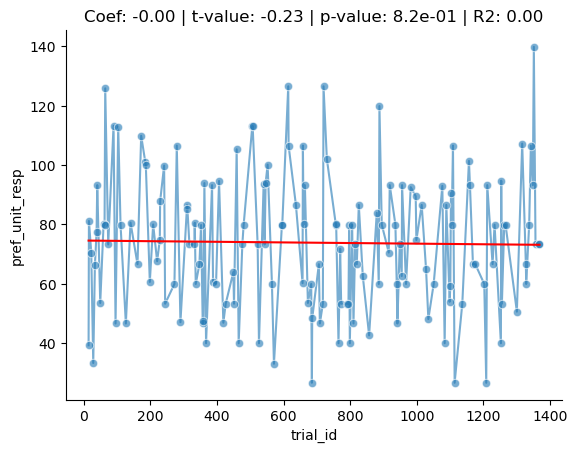

In [6]:
figdir = 'E:\\OneDrive - Harvard University\\BigGAN_Hessian\\Beto-17092020-003'
# examine the adaptation effect by linear model of resp vs trial_id as regression variable
sgtr_resp_df = pd.read_csv(join(figdir, f"single_trial_pref_unit_resp.csv"))
sns.lineplot(data=sgtr_resp_df.query(f"lin_dist == 0.0"), x="trial_id", y="pref_unit_resp", marker="o", alpha=0.6)
model = ols('pref_unit_resp ~ trial_id', data=sgtr_resp_df.query(f"lin_dist == 0.0")).fit()
print(model.summary())
# draw the model fit
sns.lineplot(x=sgtr_resp_df.query(f"lin_dist == 0.0")["trial_id"], y=model.fittedvalues, color="red")

# add a title to display the regression coef for trial_id and the tvalue and pvalue. R2
coef = model.params['trial_id']
tvalue = model.tvalues['trial_id']
pvalue = model.pvalues['trial_id']
r2 = model.rsquared
plt.title(f"Coef: {coef:.2f} | t-value: {tvalue:.2f} | p-value: {pvalue:.1e} | R2: {r2:.2f}")
plt.show()

### Mass computing the adaptation effect

0it [00:00, ?it/s]

Processing: row 0 Caos-12022024-003 Caos 1.0
                            OLS Regression Results                            
Dep. Variable:         pref_unit_resp   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     2.598
Date:                Mon, 23 Dec 2024   Prob (F-statistic):              0.111
Time:                        15:42:19   Log-Likelihood:                -330.53
No. Observations:                  86   AIC:                             665.1
Df Residuals:                      84   BIC:                             670.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Interce

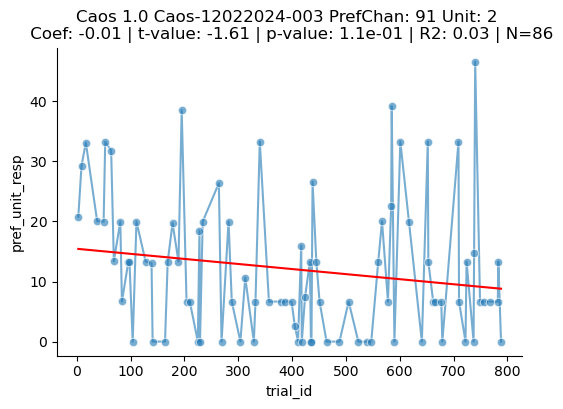

1it [00:00,  1.68it/s]

Processing: row 1 Caos-12022024-006 Caos 2.0
                            OLS Regression Results                            
Dep. Variable:         pref_unit_resp   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                    0.1809
Date:                Mon, 23 Dec 2024   Prob (F-statistic):              0.671
Time:                        15:42:20   Log-Likelihood:                -736.71
No. Observations:                 161   AIC:                             1477.
Df Residuals:                     159   BIC:                             1484.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Interce

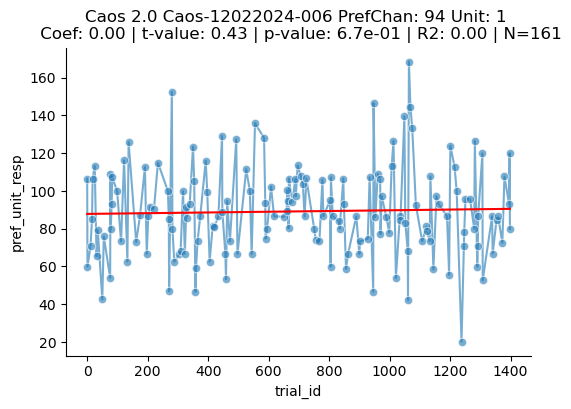

2it [00:01,  1.61it/s]

Processing: row 2 Caos-12042024-003 Caos 3.0
                            OLS Regression Results                            
Dep. Variable:         pref_unit_resp   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.4628
Date:                Mon, 23 Dec 2024   Prob (F-statistic):              0.498
Time:                        15:42:20   Log-Likelihood:                -550.36
No. Observations:                 122   AIC:                             1105.
Df Residuals:                     120   BIC:                             1110.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Interce

3it [00:01,  1.66it/s]

Processing: row 3 Caos-12042024-007 Caos 4.0
                            OLS Regression Results                            
Dep. Variable:         pref_unit_resp   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.014
Date:                Mon, 23 Dec 2024   Prob (F-statistic):              0.316
Time:                        15:42:21   Log-Likelihood:                -592.78
No. Observations:                 117   AIC:                             1190.
Df Residuals:                     115   BIC:                             1195.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Interce

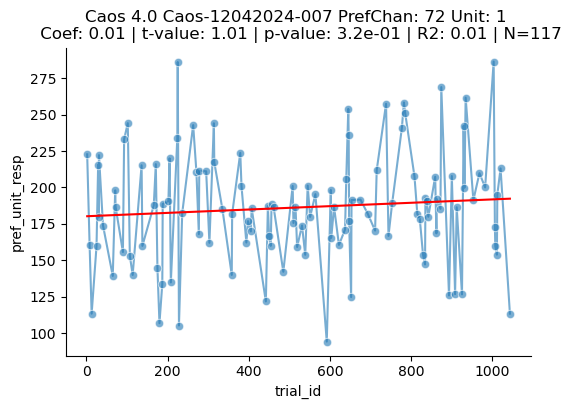

4it [00:02,  1.67it/s]

Processing: row 4 Caos-12092024-004 Caos 5.0
                            OLS Regression Results                            
Dep. Variable:         pref_unit_resp   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.1689
Date:                Mon, 23 Dec 2024   Prob (F-statistic):              0.682
Time:                        15:42:22   Log-Likelihood:                -650.51
No. Observations:                 191   AIC:                             1305.
Df Residuals:                     189   BIC:                             1312.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Interce

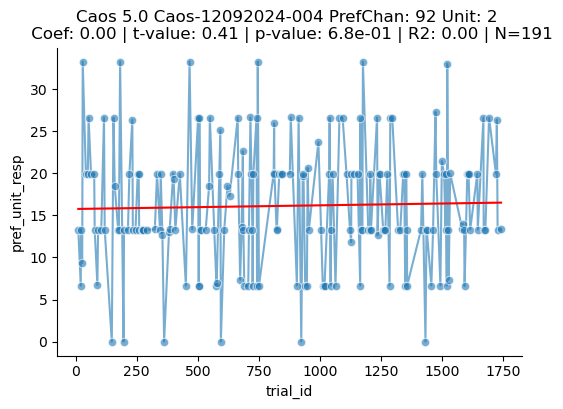

5it [00:03,  1.45it/s]

Processing: row 5 Caos-12102024-003 Caos 6.0
                            OLS Regression Results                            
Dep. Variable:         pref_unit_resp   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     3.647
Date:                Mon, 23 Dec 2024   Prob (F-statistic):             0.0580
Time:                        15:42:22   Log-Likelihood:                -718.85
No. Observations:                 157   AIC:                             1442.
Df Residuals:                     155   BIC:                             1448.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Interce

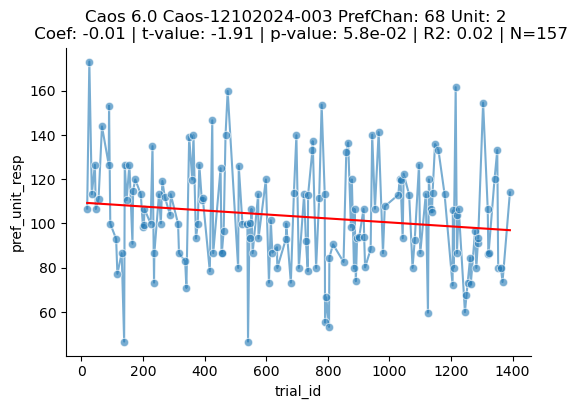

6it [00:03,  1.51it/s]

Processing: row 6 Caos-12102024-006 Caos 7.0
                            OLS Regression Results                            
Dep. Variable:         pref_unit_resp   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     4.891
Date:                Mon, 23 Dec 2024   Prob (F-statistic):             0.0280
Time:                        15:42:23   Log-Likelihood:                -1212.9
No. Observations:                 234   AIC:                             2430.
Df Residuals:                     232   BIC:                             2437.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Interce

7it [00:04,  1.57it/s]

Processing: row 7 Diablito-03122024-003 Diablito 1.0
                            OLS Regression Results                            
Dep. Variable:         pref_unit_resp   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     2.336
Date:                Mon, 23 Dec 2024   Prob (F-statistic):              0.129
Time:                        15:42:24   Log-Likelihood:                -587.52
No. Observations:                 117   AIC:                             1179.
Df Residuals:                     115   BIC:                             1185.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

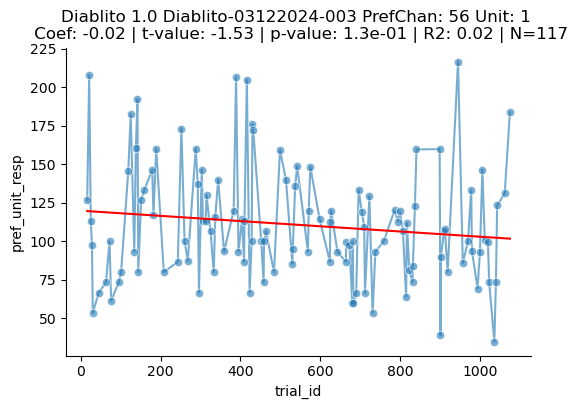

8it [00:05,  1.59it/s]

Processing: row 8 Diablito-11122024-003 Diablito 2.0
                            OLS Regression Results                            
Dep. Variable:         pref_unit_resp   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.389
Date:                Mon, 23 Dec 2024   Prob (F-statistic):              0.241
Time:                        15:42:24   Log-Likelihood:                -569.84
No. Observations:                 135   AIC:                             1144.
Df Residuals:                     133   BIC:                             1149.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

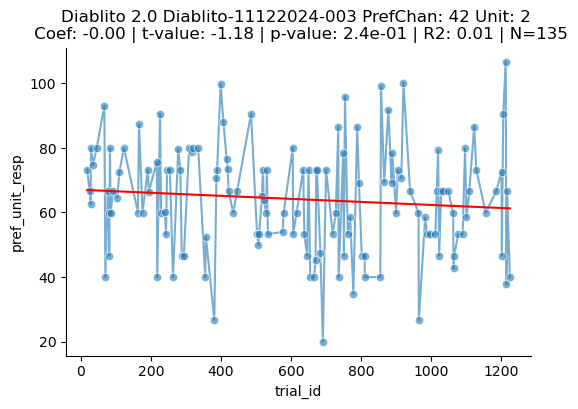

9it [00:05,  1.63it/s]

Processing: row 9 Diablito-11122024-005 Diablito 3.0
                            OLS Regression Results                            
Dep. Variable:         pref_unit_resp   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.3475
Date:                Mon, 23 Dec 2024   Prob (F-statistic):              0.556
Time:                        15:42:25   Log-Likelihood:                -880.81
No. Observations:                 195   AIC:                             1766.
Df Residuals:                     193   BIC:                             1772.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

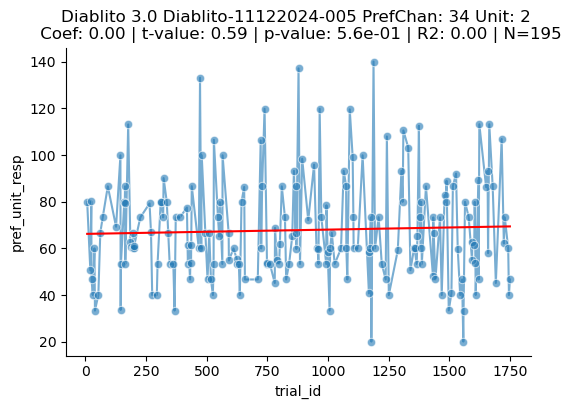

10it [00:06,  1.63it/s]

Processing: row 10 Diablito-12122024-004 Diablito 4.0
                            OLS Regression Results                            
Dep. Variable:         pref_unit_resp   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     2.433
Date:                Mon, 23 Dec 2024   Prob (F-statistic):              0.122
Time:                        15:42:25   Log-Likelihood:                -490.01
No. Observations:                 117   AIC:                             984.0
Df Residuals:                     115   BIC:                             989.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

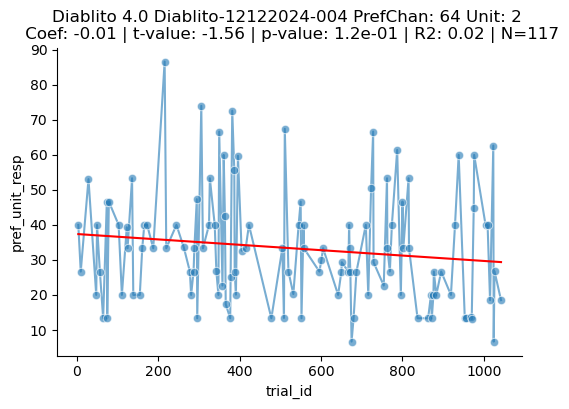

11it [00:07,  1.45it/s]

Processing: row 11 Diablito-12122024-006 Diablito 5.0
                            OLS Regression Results                            
Dep. Variable:         pref_unit_resp   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                    0.1983
Date:                Mon, 23 Dec 2024   Prob (F-statistic):              0.657
Time:                        15:42:26   Log-Likelihood:                -741.41
No. Observations:                 155   AIC:                             1487.
Df Residuals:                     153   BIC:                             1493.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

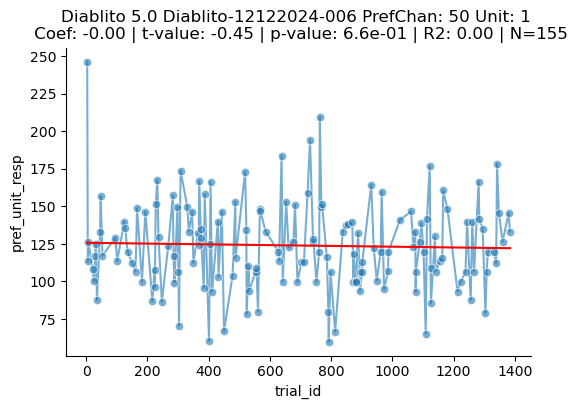

12it [00:07,  1.47it/s]

Processing: row 12 Alfa-04082020-003 Alfa 1.0
                            OLS Regression Results                            
Dep. Variable:         pref_unit_resp   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.008
Method:                 Least Squares   F-statistic:                    0.2416
Date:                Mon, 23 Dec 2024   Prob (F-statistic):              0.624
Time:                        15:42:27   Log-Likelihood:                -355.62
No. Observations:                  92   AIC:                             715.2
Df Residuals:                      90   BIC:                             720.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Interc

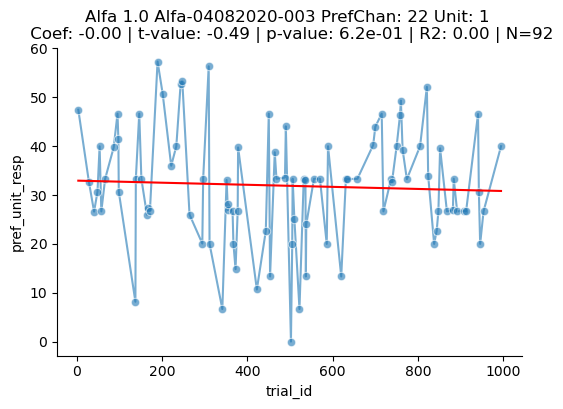

13it [00:08,  1.54it/s]

Processing: row 13 Alfa-06082020-004 Alfa 2.0
                            OLS Regression Results                            
Dep. Variable:         pref_unit_resp   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     1.378
Date:                Mon, 23 Dec 2024   Prob (F-statistic):              0.244
Time:                        15:42:27   Log-Likelihood:                -382.55
No. Observations:                  89   AIC:                             769.1
Df Residuals:                      87   BIC:                             774.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Interc

14it [00:08,  1.61it/s]

Processing: row 14 Alfa-10082020-004 Alfa 2.0
                            OLS Regression Results                            
Dep. Variable:         pref_unit_resp   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.009
Method:                 Least Squares   F-statistic:                   0.03871
Date:                Mon, 23 Dec 2024   Prob (F-statistic):              0.844
Time:                        15:42:28   Log-Likelihood:                -451.99
No. Observations:                 108   AIC:                             908.0
Df Residuals:                     106   BIC:                             913.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Interc

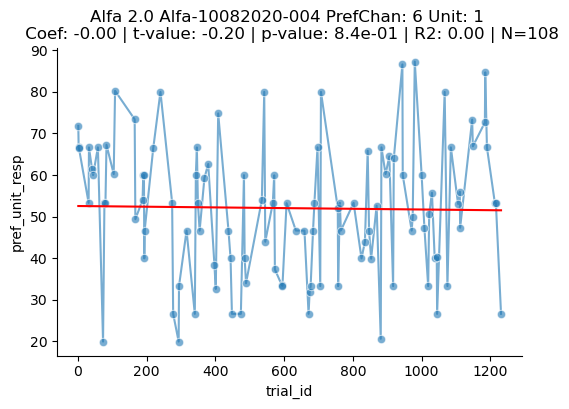

15it [00:09,  1.62it/s]

Processing: row 15 Alfa-12082020-004 Alfa 3.0
                            OLS Regression Results                            
Dep. Variable:         pref_unit_resp   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                    0.5328
Date:                Mon, 23 Dec 2024   Prob (F-statistic):              0.467
Time:                        15:42:29   Log-Likelihood:                -487.42
No. Observations:                 105   AIC:                             978.8
Df Residuals:                     103   BIC:                             984.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Interc

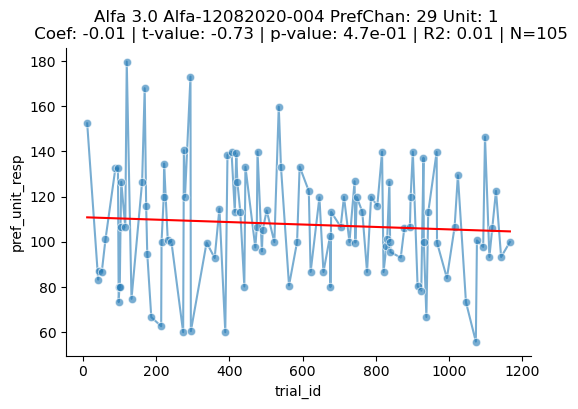

16it [00:10,  1.63it/s]

Processing: row 16 Alfa-14082020-003 Alfa 4.0
                            OLS Regression Results                            
Dep. Variable:         pref_unit_resp   R-squared:                       0.059
Model:                            OLS   Adj. R-squared:                  0.052
Method:                 Least Squares   F-statistic:                     8.799
Date:                Mon, 23 Dec 2024   Prob (F-statistic):            0.00354
Time:                        15:42:29   Log-Likelihood:                -670.89
No. Observations:                 142   AIC:                             1346.
Df Residuals:                     140   BIC:                             1352.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Interc

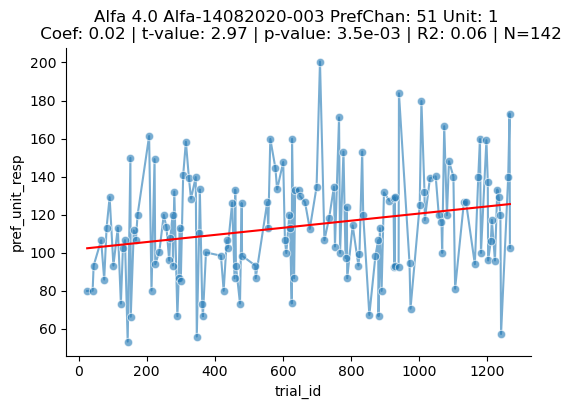

17it [00:10,  1.47it/s]

Processing: row 17 Alfa-25082020-007 Alfa 5.0
                            OLS Regression Results                            
Dep. Variable:         pref_unit_resp   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                 -0.010
Method:                 Least Squares   F-statistic:                    0.3705
Date:                Mon, 23 Dec 2024   Prob (F-statistic):              0.545
Time:                        15:42:30   Log-Likelihood:                -287.64
No. Observations:                  63   AIC:                             579.3
Df Residuals:                      61   BIC:                             583.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Interc

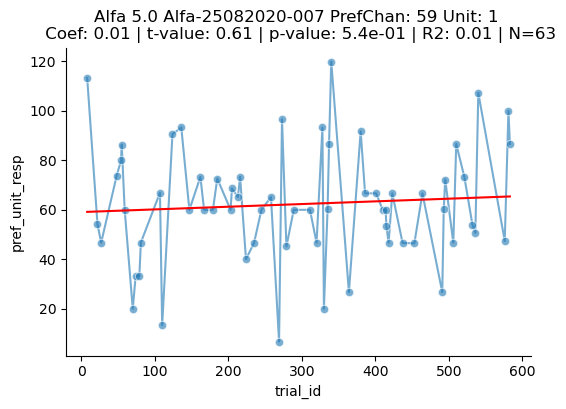

18it [00:11,  1.53it/s]

Processing: row 18 Alfa-27082020-003 Alfa 6.0
                            OLS Regression Results                            
Dep. Variable:         pref_unit_resp   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.151
Date:                Mon, 23 Dec 2024   Prob (F-statistic):              0.285
Time:                        15:42:31   Log-Likelihood:                -822.88
No. Observations:                 178   AIC:                             1650.
Df Residuals:                     176   BIC:                             1656.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Interc

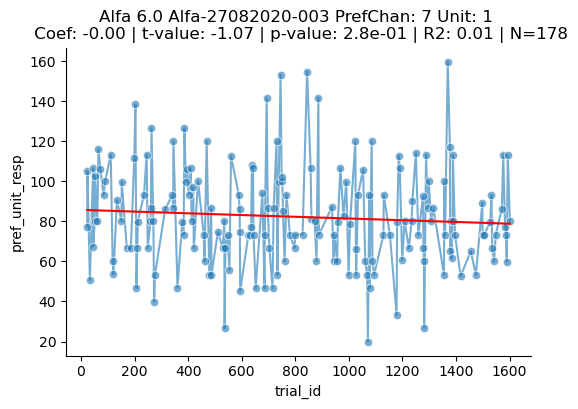

19it [00:12,  1.53it/s]

Processing: row 19 Alfa-01092020-004 Alfa 7.0
                            OLS Regression Results                            
Dep. Variable:         pref_unit_resp   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.8172
Date:                Mon, 23 Dec 2024   Prob (F-statistic):              0.367
Time:                        15:42:31   Log-Likelihood:                -763.27
No. Observations:                 153   AIC:                             1531.
Df Residuals:                     151   BIC:                             1537.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Interc

20it [00:12,  1.52it/s]

Processing: row 20 Alfa-02092020-004 Alfa 8.0
                            OLS Regression Results                            
Dep. Variable:         pref_unit_resp   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     2.088
Date:                Mon, 23 Dec 2024   Prob (F-statistic):              0.151
Time:                        15:42:32   Log-Likelihood:                -777.71
No. Observations:                 151   AIC:                             1559.
Df Residuals:                     149   BIC:                             1565.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Interc

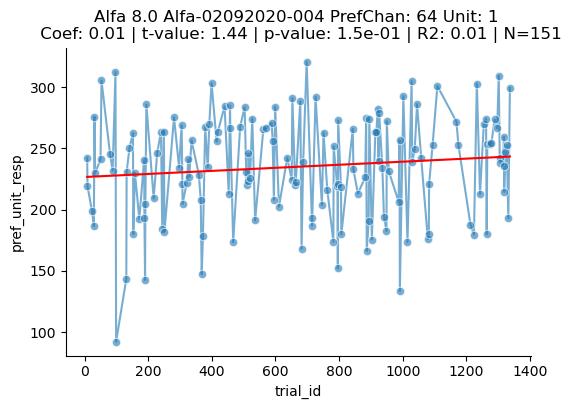

21it [00:13,  1.57it/s]

Processing: row 21 Alfa-02092020-006 Alfa 9.0
                            OLS Regression Results                            
Dep. Variable:         pref_unit_resp   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.007
Method:                 Least Squares   F-statistic:                    0.1365
Date:                Mon, 23 Dec 2024   Prob (F-statistic):              0.712
Time:                        15:42:33   Log-Likelihood:                -595.63
No. Observations:                 124   AIC:                             1195.
Df Residuals:                     122   BIC:                             1201.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Interc

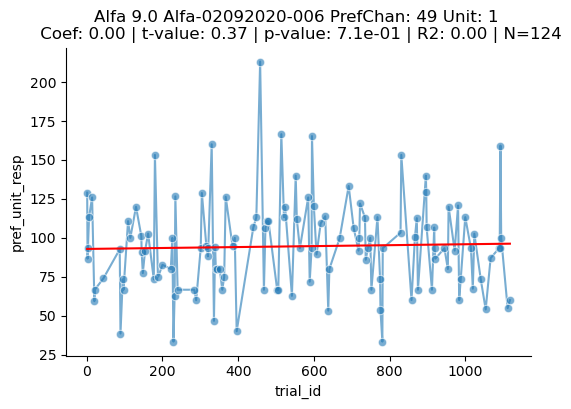

22it [00:14,  1.60it/s]

Processing: row 22 Alfa-08092020-004 Alfa 10.0
                            OLS Regression Results                            
Dep. Variable:         pref_unit_resp   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     2.705
Date:                Mon, 23 Dec 2024   Prob (F-statistic):              0.102
Time:                        15:42:33   Log-Likelihood:                -758.29
No. Observations:                 155   AIC:                             1521.
Df Residuals:                     153   BIC:                             1527.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Inter

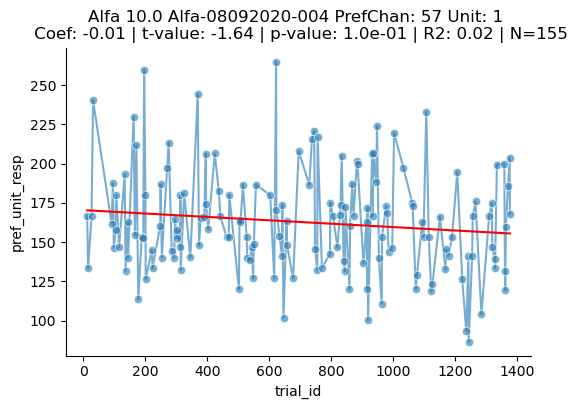

23it [00:14,  1.44it/s]

Processing: row 23 Alfa-11092020-003 Alfa 11.0
                            OLS Regression Results                            
Dep. Variable:         pref_unit_resp   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     2.516
Date:                Mon, 23 Dec 2024   Prob (F-statistic):              0.115
Time:                        15:42:34   Log-Likelihood:                -669.95
No. Observations:                 152   AIC:                             1344.
Df Residuals:                     150   BIC:                             1350.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Inter

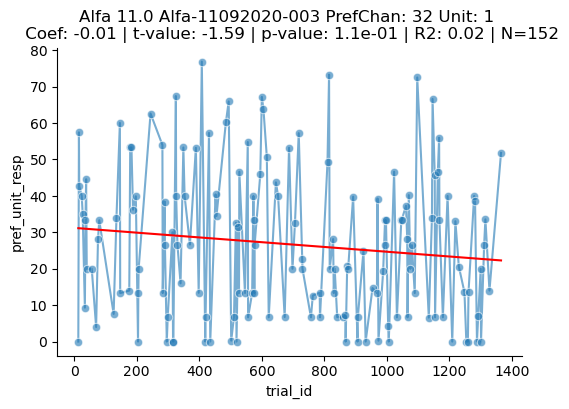

24it [00:15,  1.46it/s]

Processing: row 24 Alfa-11092020-006 Alfa 12.0
                            OLS Regression Results                            
Dep. Variable:         pref_unit_resp   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     2.599
Date:                Mon, 23 Dec 2024   Prob (F-statistic):              0.110
Time:                        15:42:35   Log-Likelihood:                -558.21
No. Observations:                 122   AIC:                             1120.
Df Residuals:                     120   BIC:                             1126.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Inter

25it [00:16,  1.53it/s]

Processing: row 25 Alfa-16092020-003 Alfa 13.0
                            OLS Regression Results                            
Dep. Variable:         pref_unit_resp   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.4400
Date:                Mon, 23 Dec 2024   Prob (F-statistic):              0.508
Time:                        15:42:35   Log-Likelihood:                -695.30
No. Observations:                 153   AIC:                             1395.
Df Residuals:                     151   BIC:                             1401.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Inter

26it [00:16,  1.56it/s]

Processing: row 26 Alfa-16092020-005 Alfa 14.0
                            OLS Regression Results                            
Dep. Variable:         pref_unit_resp   R-squared:                       0.109
Model:                            OLS   Adj. R-squared:                  0.102
Method:                 Least Squares   F-statistic:                     15.35
Date:                Mon, 23 Dec 2024   Prob (F-statistic):           0.000146
Time:                        15:42:36   Log-Likelihood:                -495.70
No. Observations:                 127   AIC:                             995.4
Df Residuals:                     125   BIC:                             1001.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Inter

27it [00:17,  1.60it/s]c:\Users\ponce\.conda\envs\torch\lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Processing: row 27 Alfa-27102020-007 Alfa 15.0
                            OLS Regression Results                            
Dep. Variable:         pref_unit_resp   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                 -0.053
Method:                 Least Squares   F-statistic:                    0.3469
Date:                Mon, 23 Dec 2024   Prob (F-statistic):              0.567
Time:                        15:42:36   Log-Likelihood:                -58.943
No. Observations:                  14   AIC:                             121.9
Df Residuals:                      12   BIC:                             123.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Inter

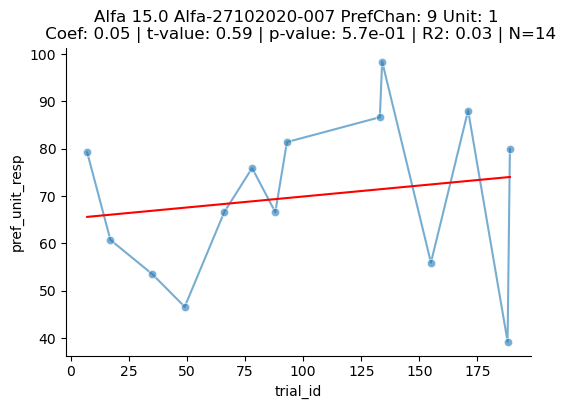

28it [00:17,  1.63it/s]c:\Users\ponce\.conda\envs\torch\lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Processing: row 28 Alfa-27102020-008 Alfa 15.0
                            OLS Regression Results                            
Dep. Variable:         pref_unit_resp   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                 -0.036
Method:                 Least Squares   F-statistic:                    0.4798
Date:                Mon, 23 Dec 2024   Prob (F-statistic):              0.500
Time:                        15:42:37   Log-Likelihood:                -68.649
No. Observations:                  16   AIC:                             141.3
Df Residuals:                      14   BIC:                             142.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Inter

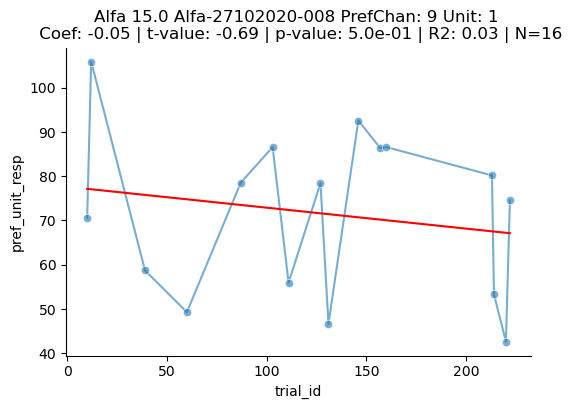

29it [00:18,  1.50it/s]c:\Users\ponce\.conda\envs\torch\lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Processing: row 29 Alfa-27102020-009 Alfa 15.0
                            OLS Regression Results                            
Dep. Variable:         pref_unit_resp   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                 -0.060
Method:                 Least Squares   F-statistic:                    0.1557
Date:                Mon, 23 Dec 2024   Prob (F-statistic):              0.699
Time:                        15:42:38   Log-Likelihood:                -70.242
No. Observations:                  16   AIC:                             144.5
Df Residuals:                      14   BIC:                             146.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Inter

30it [00:19,  1.55it/s]c:\Users\ponce\.conda\envs\torch\lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Processing: row 30 Alfa-04112020-005 Alfa 16.0
                            OLS Regression Results                            
Dep. Variable:         pref_unit_resp   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                 -0.030
Method:                 Least Squares   F-statistic:                    0.5025
Date:                Mon, 23 Dec 2024   Prob (F-statistic):              0.489
Time:                        15:42:38   Log-Likelihood:                -89.360
No. Observations:                  18   AIC:                             182.7
Df Residuals:                      16   BIC:                             184.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Inter

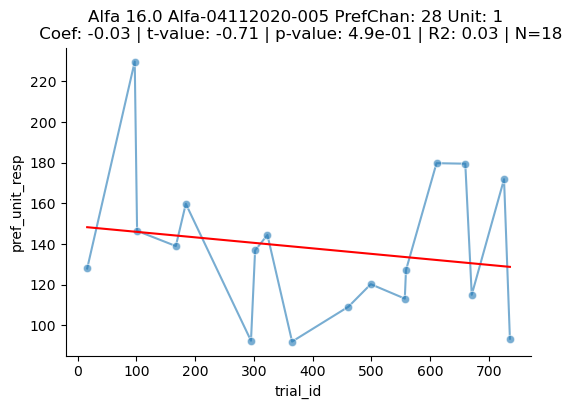

31it [00:19,  1.59it/s]c:\Users\ponce\.conda\envs\torch\lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Processing: row 31 Alfa-06112020-006 Alfa 17.0
                            OLS Regression Results                            
Dep. Variable:         pref_unit_resp   R-squared:                       0.157
Model:                            OLS   Adj. R-squared:                  0.087
Method:                 Least Squares   F-statistic:                     2.235
Date:                Mon, 23 Dec 2024   Prob (F-statistic):              0.161
Time:                        15:42:39   Log-Likelihood:                -68.977
No. Observations:                  14   AIC:                             142.0
Df Residuals:                      12   BIC:                             143.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Inter

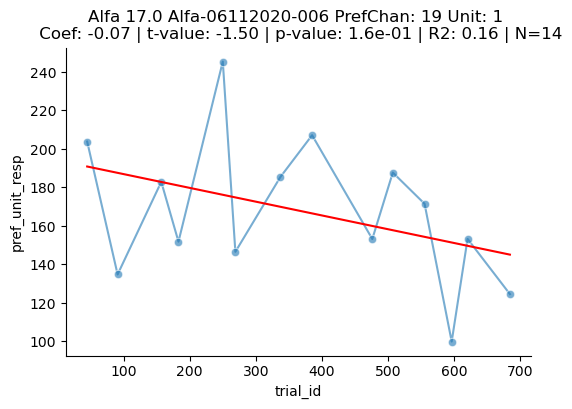

32it [00:20,  1.61it/s]c:\Users\ponce\.conda\envs\torch\lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Processing: row 32 Alfa-12012021-003 Alfa 18.0
                            OLS Regression Results                            
Dep. Variable:         pref_unit_resp   R-squared:                       0.052
Model:                            OLS   Adj. R-squared:                 -0.028
Method:                 Least Squares   F-statistic:                    0.6517
Date:                Mon, 23 Dec 2024   Prob (F-statistic):              0.435
Time:                        15:42:40   Log-Likelihood:                -49.494
No. Observations:                  14   AIC:                             103.0
Df Residuals:                      12   BIC:                             104.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Inter

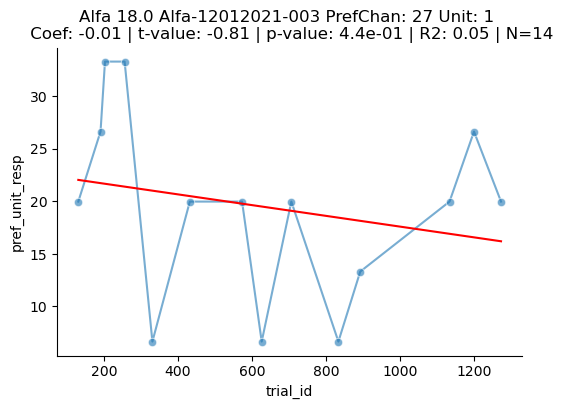

33it [00:21,  1.68it/s]c:\Users\ponce\.conda\envs\torch\lib\site-packages\statsmodels\stats\stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
c:\Users\ponce\.conda\envs\torch\lib\site-packages\statsmodels\stats\stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
c:\Users\ponce\.conda\envs\torch\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 2 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
c:\Users\ponce\.conda\envs\torch\lib\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide b

Processing: row 33 Alfa-13012021-003 Alfa 19.0
                            OLS Regression Results                            
Dep. Variable:         pref_unit_resp   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Mon, 23 Dec 2024   Prob (F-statistic):                nan
Time:                        15:42:40   Log-Likelihood:                 59.545
No. Observations:                   2   AIC:                            -115.1
Df Residuals:                       0   BIC:                            -117.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Inter

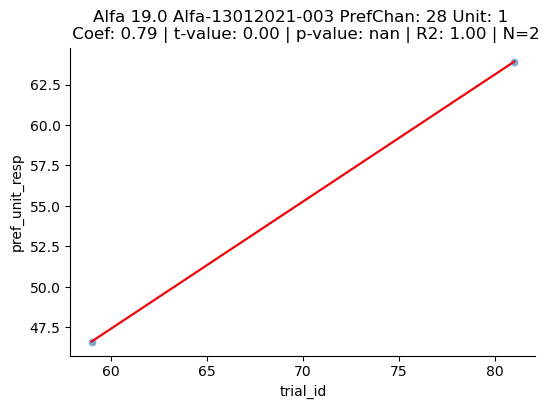

34it [00:21,  1.72it/s]c:\Users\ponce\.conda\envs\torch\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


Processing: row 34 Alfa-19022021-004 Alfa 20.0
                            OLS Regression Results                            
Dep. Variable:         pref_unit_resp   R-squared:                       0.109
Model:                            OLS   Adj. R-squared:                 -0.114
Method:                 Least Squares   F-statistic:                    0.4890
Date:                Mon, 23 Dec 2024   Prob (F-statistic):              0.523
Time:                        15:42:41   Log-Likelihood:                -26.740
No. Observations:                   6   AIC:                             57.48
Df Residuals:                       4   BIC:                             57.06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Inter

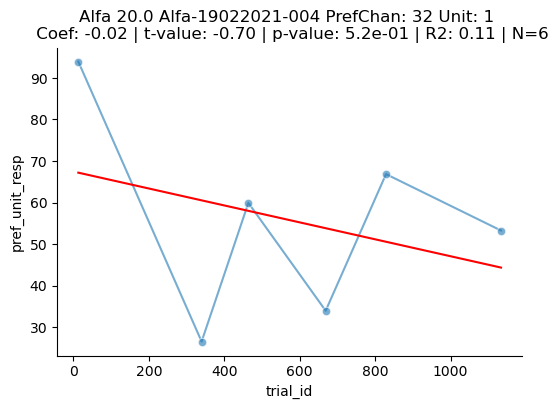

35it [00:22,  1.55it/s]c:\Users\ponce\.conda\envs\torch\lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Processing: row 35 Alfa-25022021-004 Alfa 21.0
                            OLS Regression Results                            
Dep. Variable:         pref_unit_resp   R-squared:                       0.369
Model:                            OLS   Adj. R-squared:                  0.320
Method:                 Least Squares   F-statistic:                     7.586
Date:                Mon, 23 Dec 2024   Prob (F-statistic):             0.0164
Time:                        15:42:41   Log-Likelihood:                -68.769
No. Observations:                  15   AIC:                             141.5
Df Residuals:                      13   BIC:                             143.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Inter

36it [00:23,  1.58it/s]c:\Users\ponce\.conda\envs\torch\lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Processing: row 36 Alfa-26022021-005 Alfa 22.0
                            OLS Regression Results                            
Dep. Variable:         pref_unit_resp   R-squared:                       0.426
Model:                            OLS   Adj. R-squared:                  0.354
Method:                 Least Squares   F-statistic:                     5.926
Date:                Mon, 23 Dec 2024   Prob (F-statistic):             0.0409
Time:                        15:42:42   Log-Likelihood:                -41.069
No. Observations:                  10   AIC:                             86.14
Df Residuals:                       8   BIC:                             86.74
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Inter

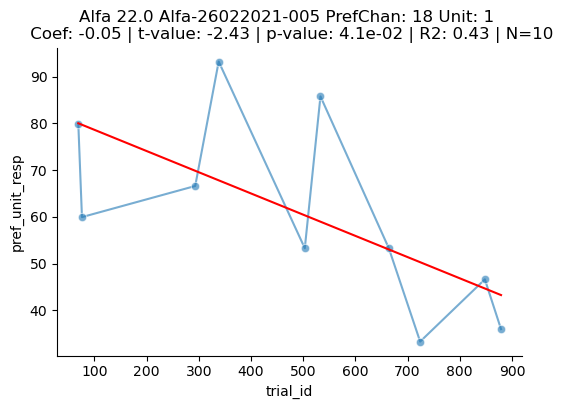

37it [00:23,  1.58it/s]c:\Users\ponce\.conda\envs\torch\lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Processing: row 37 Alfa-12032021-005 Alfa 23.0
                            OLS Regression Results                            
Dep. Variable:         pref_unit_resp   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                 -0.079
Method:                 Least Squares   F-statistic:                   0.05011
Date:                Mon, 23 Dec 2024   Prob (F-statistic):              0.827
Time:                        15:42:43   Log-Likelihood:                -52.698
No. Observations:                  14   AIC:                             109.4
Df Residuals:                      12   BIC:                             110.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Inter

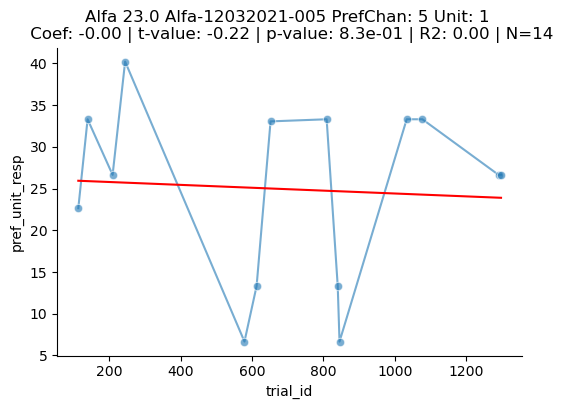

38it [00:24,  1.60it/s]c:\Users\ponce\.conda\envs\torch\lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Processing: row 38 Alfa-01042021-004 Alfa 24.0
                            OLS Regression Results                            
Dep. Variable:         pref_unit_resp   R-squared:                       0.151
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     1.783
Date:                Mon, 23 Dec 2024   Prob (F-statistic):              0.211
Time:                        15:42:43   Log-Likelihood:                -49.720
No. Observations:                  12   AIC:                             103.4
Df Residuals:                      10   BIC:                             104.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Inter

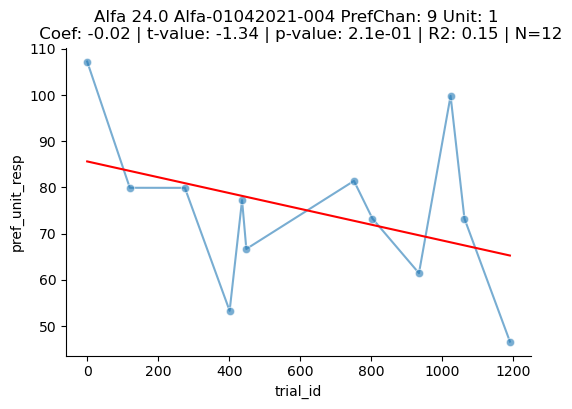

39it [00:24,  1.63it/s]c:\Users\ponce\.conda\envs\torch\lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Processing: row 39 Alfa-08042021-003 Alfa 25.0
                            OLS Regression Results                            
Dep. Variable:         pref_unit_resp   R-squared:                       0.109
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     1.465
Date:                Mon, 23 Dec 2024   Prob (F-statistic):              0.249
Time:                        15:42:44   Log-Likelihood:                -66.497
No. Observations:                  14   AIC:                             137.0
Df Residuals:                      12   BIC:                             138.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Inter

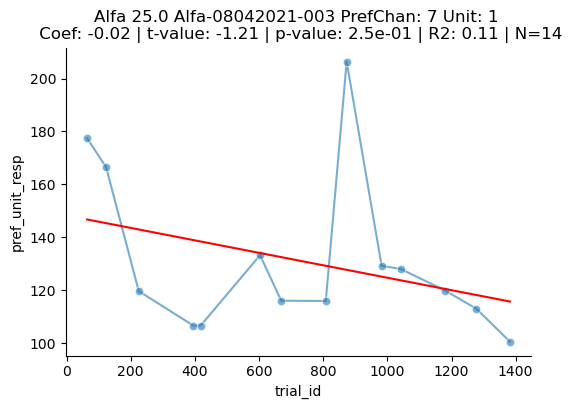

40it [00:25,  1.67it/s]c:\Users\ponce\.conda\envs\torch\lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Processing: row 40 Alfa-14052021-004 Alfa 26.0
                            OLS Regression Results                            
Dep. Variable:         pref_unit_resp   R-squared:                       0.123
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     1.408
Date:                Mon, 23 Dec 2024   Prob (F-statistic):              0.263
Time:                        15:42:44   Log-Likelihood:                -56.940
No. Observations:                  12   AIC:                             117.9
Df Residuals:                      10   BIC:                             118.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Inter

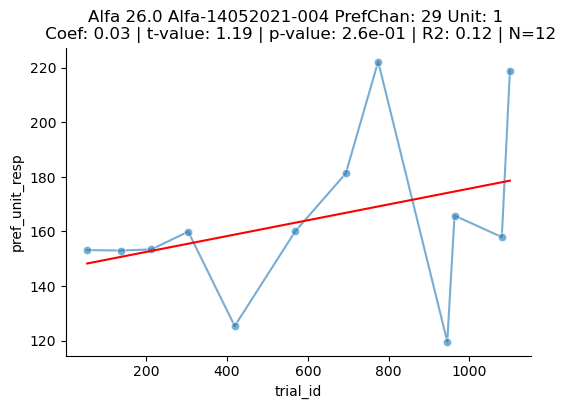

41it [00:26,  1.53it/s]

Processing: row 41 Beto-27072020-004 Beto 1.0
                            OLS Regression Results                            
Dep. Variable:         pref_unit_resp   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     2.124
Date:                Mon, 23 Dec 2024   Prob (F-statistic):              0.146
Time:                        15:42:45   Log-Likelihood:                -1196.7
No. Observations:                 246   AIC:                             2397.
Df Residuals:                     244   BIC:                             2404.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Interc

42it [00:26,  1.58it/s]

Processing: row 42 Beto-05082020-003 Beto 2.0
                            OLS Regression Results                            
Dep. Variable:         pref_unit_resp   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     2.581
Date:                Mon, 23 Dec 2024   Prob (F-statistic):              0.110
Time:                        15:42:46   Log-Likelihood:                -713.80
No. Observations:                 146   AIC:                             1432.
Df Residuals:                     144   BIC:                             1438.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Interc

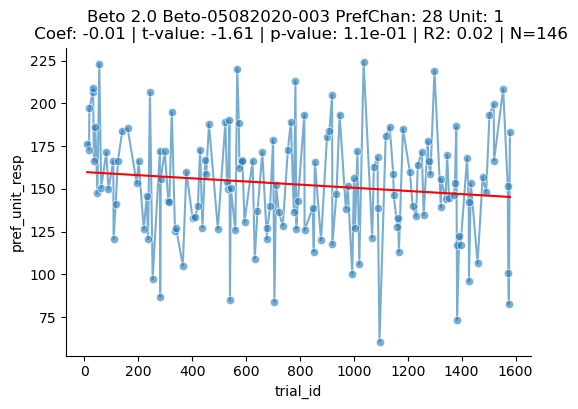

43it [00:27,  1.58it/s]

Processing: row 43 Beto-07082020-003 Beto 3.0
                            OLS Regression Results                            
Dep. Variable:         pref_unit_resp   R-squared:                       0.047
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     5.030
Date:                Mon, 23 Dec 2024   Prob (F-statistic):             0.0271
Time:                        15:42:46   Log-Likelihood:                -524.46
No. Observations:                 103   AIC:                             1053.
Df Residuals:                     101   BIC:                             1058.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Interc

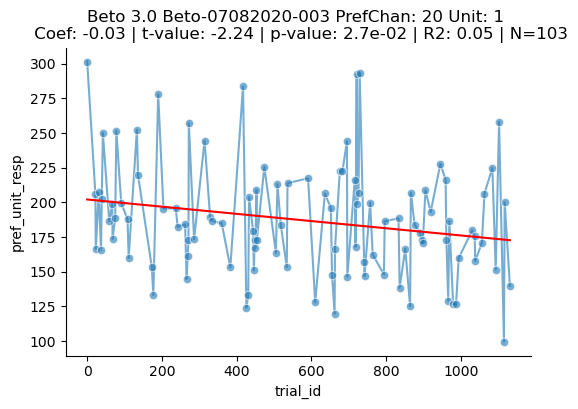

44it [00:28,  1.59it/s]

Processing: row 44 Beto-11082020-004 Beto 4.0
                            OLS Regression Results                            
Dep. Variable:         pref_unit_resp   R-squared:                       0.164
Model:                            OLS   Adj. R-squared:                  0.155
Method:                 Least Squares   F-statistic:                     20.14
Date:                Mon, 23 Dec 2024   Prob (F-statistic):           1.88e-05
Time:                        15:42:47   Log-Likelihood:                -558.39
No. Observations:                 105   AIC:                             1121.
Df Residuals:                     103   BIC:                             1126.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Interc

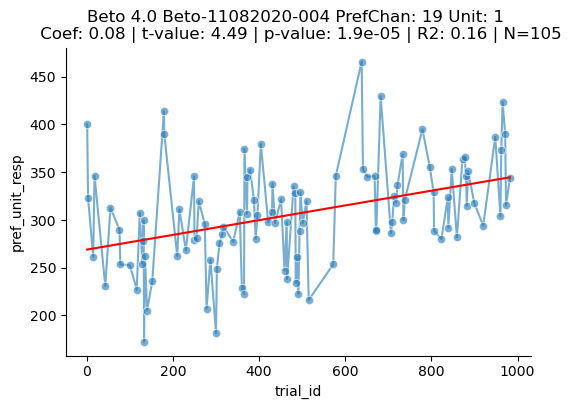

45it [00:28,  1.63it/s]

Processing: row 45 Beto-13082020-004 Beto 5.0
                            OLS Regression Results                            
Dep. Variable:         pref_unit_resp   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     4.616
Date:                Mon, 23 Dec 2024   Prob (F-statistic):             0.0334
Time:                        15:42:48   Log-Likelihood:                -629.21
No. Observations:                 141   AIC:                             1262.
Df Residuals:                     139   BIC:                             1268.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Interc

46it [00:29,  1.67it/s]

Processing: row 46 Beto-17082020-004 Beto 6.0
                            OLS Regression Results                            
Dep. Variable:         pref_unit_resp   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.009
Method:                 Least Squares   F-statistic:                   0.03507
Date:                Mon, 23 Dec 2024   Prob (F-statistic):              0.852
Time:                        15:42:48   Log-Likelihood:                -541.19
No. Observations:                 109   AIC:                             1086.
Df Residuals:                     107   BIC:                             1092.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Interc

47it [00:29,  1.50it/s]c:\Users\ponce\.conda\envs\torch\lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Processing: row 47 Beto-18082020-003 Beto 7.0
                            OLS Regression Results                            
Dep. Variable:         pref_unit_resp   R-squared:                       0.055
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.9329
Date:                Mon, 23 Dec 2024   Prob (F-statistic):              0.348
Time:                        15:42:49   Log-Likelihood:                -78.912
No. Observations:                  18   AIC:                             161.8
Df Residuals:                      16   BIC:                             163.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Interc

48it [00:30,  1.52it/s]

Processing: row 48 Beto-20082020-004 Beto 8.0
                            OLS Regression Results                            
Dep. Variable:         pref_unit_resp   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.010
Method:                 Least Squares   F-statistic:                   0.03274
Date:                Mon, 23 Dec 2024   Prob (F-statistic):              0.857
Time:                        15:42:50   Log-Likelihood:                -436.26
No. Observations:                  95   AIC:                             876.5
Df Residuals:                      93   BIC:                             881.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Interc

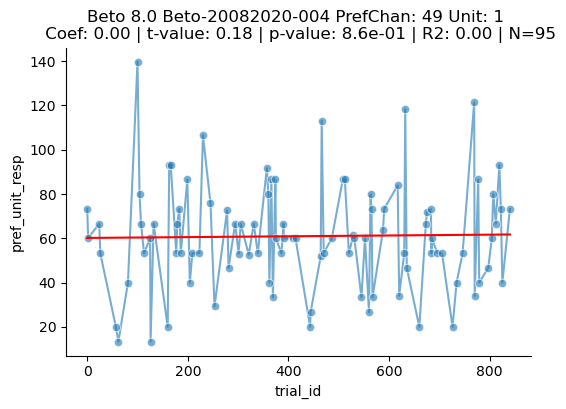

49it [00:31,  1.59it/s]c:\Users\ponce\.conda\envs\torch\lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Processing: row 49 Beto-24082020-003 Beto 9.0
                            OLS Regression Results                            
Dep. Variable:         pref_unit_resp   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                 -0.036
Method:                 Least Squares   F-statistic:                    0.5430
Date:                Mon, 23 Dec 2024   Prob (F-statistic):              0.475
Time:                        15:42:50   Log-Likelihood:                -69.204
No. Observations:                  14   AIC:                             142.4
Df Residuals:                      12   BIC:                             143.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Interc

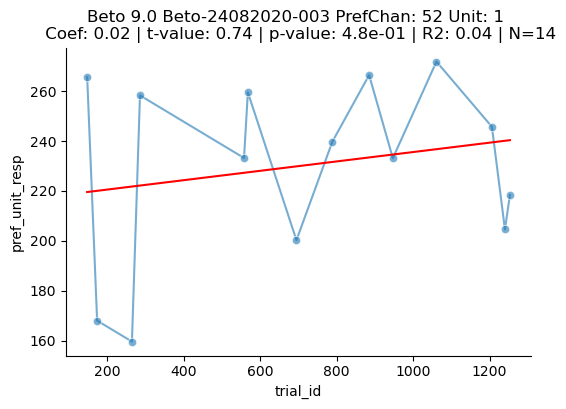

50it [00:31,  1.63it/s]c:\Users\ponce\.conda\envs\torch\lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Processing: row 50 Beto-31082020-003 Beto 10.0
                            OLS Regression Results                            
Dep. Variable:         pref_unit_resp   R-squared:                       0.178
Model:                            OLS   Adj. R-squared:                  0.096
Method:                 Least Squares   F-statistic:                     2.168
Date:                Mon, 23 Dec 2024   Prob (F-statistic):              0.172
Time:                        15:42:51   Log-Likelihood:                -56.468
No. Observations:                  12   AIC:                             116.9
Df Residuals:                      10   BIC:                             117.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Inter

51it [00:32,  1.67it/s]c:\Users\ponce\.conda\envs\torch\lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Processing: row 51 Beto-07092020-003 Beto 11.0
                            OLS Regression Results                            
Dep. Variable:         pref_unit_resp   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.122
Method:                 Least Squares   F-statistic:                   0.02167
Date:                Mon, 23 Dec 2024   Prob (F-statistic):              0.887
Time:                        15:42:51   Log-Likelihood:                -50.179
No. Observations:                  10   AIC:                             104.4
Df Residuals:                       8   BIC:                             105.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Inter

52it [00:32,  1.70it/s]

Processing: row 52 Beto-10092020-003 Beto 12.0
                            OLS Regression Results                            
Dep. Variable:         pref_unit_resp   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.006
Method:                 Least Squares   F-statistic:                   0.07003
Date:                Mon, 23 Dec 2024   Prob (F-statistic):              0.792
Time:                        15:42:52   Log-Likelihood:                -729.73
No. Observations:                 152   AIC:                             1463.
Df Residuals:                     150   BIC:                             1470.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Inter

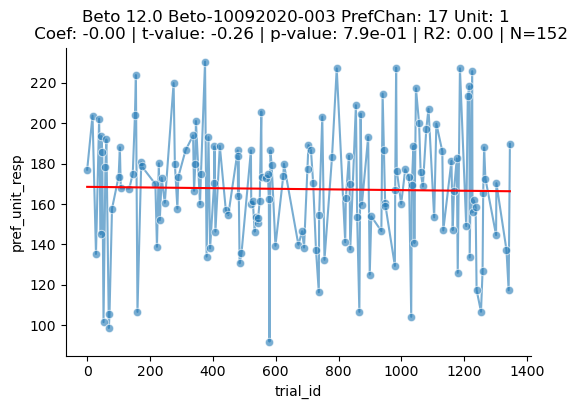

53it [00:33,  1.50it/s]

Processing: row 53 Beto-14092020-004 Beto 13.0
                            OLS Regression Results                            
Dep. Variable:         pref_unit_resp   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                    0.3768
Date:                Mon, 23 Dec 2024   Prob (F-statistic):              0.540
Time:                        15:42:53   Log-Likelihood:                -659.14
No. Observations:                 130   AIC:                             1322.
Df Residuals:                     128   BIC:                             1328.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Inter

54it [00:34,  1.54it/s]

Processing: row 54 Beto-17092020-003 Beto 14.0
                            OLS Regression Results                            
Dep. Variable:         pref_unit_resp   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.006
Method:                 Least Squares   F-statistic:                   0.05104
Date:                Mon, 23 Dec 2024   Prob (F-statistic):              0.822
Time:                        15:42:53   Log-Likelihood:                -703.98
No. Observations:                 155   AIC:                             1412.
Df Residuals:                     153   BIC:                             1418.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Inter

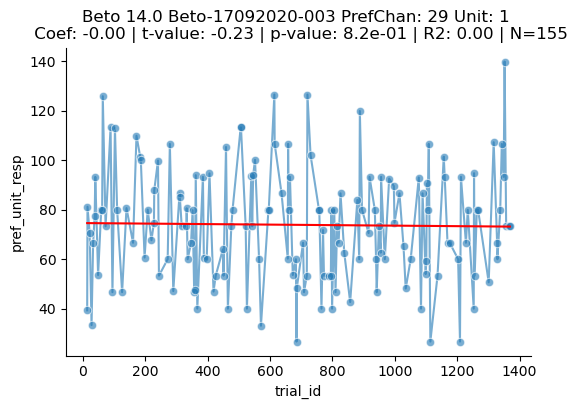

55it [00:34,  1.57it/s]


In [4]:
ExpRecord_Hessian_All = pd.read_csv(r"ExpRecord_BigGAN_Hessian_tuning_ABCD_w_meta.csv")
ExpRecord_Evol_All = pd.read_csv(r"ExpRecord_BigGAN_Hessian_Evol_ABCD_w_meta.csv")
figroot = f"E:\OneDrive - Harvard University\BigGAN_Hessian"
tuning_stats_synopsis = []
# ExpRecord_Hessian_All = ExpRecord_Hessian_All.sort_values(by=["Animal", "Expi"]).reset_index(drop=True)
for rowi, exprow in tqdm(ExpRecord_Hessian_All.iterrows()):
    print("Processing: row", rowi, exprow.ephysFN, exprow.Animal, exprow.Expi)
    expstr = f"{exprow.Animal} {exprow.Expi} {exprow.ephysFN} PrefChan: {int(exprow.pref_chan)} Unit: {int(exprow.pref_unit)}"
    figdir = join(figroot, exprow.ephysFN)
    # examine the adaptation effect by linear model of resp vs trial_id as regression variable
    sgtr_resp_df = pd.read_csv(join(figdir, f"single_trial_pref_unit_resp.csv"))
    origin_resp_df = sgtr_resp_df.query(f"lin_dist == 0.0")
    fig = plt.figure(figsize=(6, 4))
    sns.lineplot(data=origin_resp_df, x="trial_id", y="pref_unit_resp", marker="o", alpha=0.6)
    model = ols('pref_unit_resp ~ trial_id', data=origin_resp_df).fit()
    print(model.summary())
    # draw the model fit
    sns.lineplot(x=origin_resp_df["trial_id"], y=model.fittedvalues, color="red")
    # add a title to display the regression coef for trial_id and the tvalue and pvalue. R2
    coef = model.params['trial_id']
    tvalue = model.tvalues['trial_id']
    pvalue = model.pvalues['trial_id']
    r2 = model.rsquared
    plt.title(f"{expstr} \n Coef: {coef:.2f} | t-value: {tvalue:.2f} | p-value: {pvalue:.1e} | R2: {r2:.2f} | N={len(origin_resp_df)}")
    saveallforms(figdir, f"origin_image_adaptation_effect_prefunit", fig)
    plt.show()

### Examine the adaptation effects

In [8]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         pref_unit_resp   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.006
Method:                 Least Squares   F-statistic:                   0.05104
Date:                Mon, 23 Dec 2024   Prob (F-statistic):              0.822
Time:                        15:57:14   Log-Likelihood:                -703.98
No. Observations:                 155   AIC:                             1412.
Df Residuals:                     153   BIC:                             1418.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     74.5593      3.637     20.503      0.0

In [9]:
ExpRecord_Hessian_All = pd.read_csv(r"ExpRecord_BigGAN_Hessian_tuning_ABCD_w_meta.csv")
ExpRecord_Evol_All = pd.read_csv(r"ExpRecord_BigGAN_Hessian_Evol_ABCD_w_meta.csv")
figroot = f"E:\OneDrive - Harvard University\BigGAN_Hessian"
syndir = join(figroot, "synopsis")
adaptation_effect_df = []
adaptation_model_col = [ ]
# ExpRecord_Hessian_All = ExpRecord_Hessian_All.sort_values(by=["Animal", "Expi"]).reset_index(drop=True)
for rowi, exprow in tqdm(ExpRecord_Hessian_All.iterrows()):
    print("Processing: row", rowi, exprow.ephysFN, exprow.Animal, exprow.Expi)
    expstr = f"{exprow.Animal} {exprow.Expi} {exprow.ephysFN} PrefChan: {int(exprow.pref_chan)} Unit: {int(exprow.pref_unit)}"
    figdir = join(figroot, exprow.ephysFN)
    # examine the adaptation effect by linear model of resp vs trial_id as regression variable
    sgtr_resp_df = pd.read_csv(join(figdir, f"single_trial_pref_unit_resp.csv"))
    origin_resp_df = sgtr_resp_df.query(f"lin_dist == 0.0")
    model = ols('pref_unit_resp ~ trial_id', data=origin_resp_df).fit()
    # print(model.summary())
    # add a title to display the regression coef for trial_id and the tvalue and pvalue. R2
    intercept = model.params['Intercept']
    coef = model.params['trial_id']
    tvalue = model.tvalues['trial_id']
    pvalue = model.pvalues['trial_id']
    Fvalue = model.fvalue
    Fpvalue = model.f_pvalue
    r2 = model.rsquared
    adaptation_model_col.append({"meta": exprow, "model": model})
    adaptation_effect_df.append({"Animal": exprow.Animal, "Expi": exprow.Expi, "ephysFN": exprow.ephysFN, "pref_chan": exprow.pref_chan, "pref_unit": exprow.pref_unit, 
                                 "coef": coef, "tvalue": tvalue, "pvalue": pvalue, "Fvalue": Fvalue, "Fpvalue": Fpvalue,
                                 "intercept": intercept, "r2": r2, "N": len(origin_resp_df)})
    
pkl.dump(adaptation_model_col, open(join(syndir, "adaptation_regression_model_collection.pkl"), "wb"))
adaptation_effect_df = pd.DataFrame(adaptation_effect_df)
adaptation_effect_df.to_csv(join(syndir, "adaptation_effect_synopsis.csv"), index=False)

16it [00:00, 75.65it/s]

Processing: row 0 Caos-12022024-003 Caos 1.0
Processing: row 1 Caos-12022024-006 Caos 2.0
Processing: row 2 Caos-12042024-003 Caos 3.0
Processing: row 3 Caos-12042024-007 Caos 4.0
Processing: row 4 Caos-12092024-004 Caos 5.0
Processing: row 5 Caos-12102024-003 Caos 6.0
Processing: row 6 Caos-12102024-006 Caos 7.0
Processing: row 7 Diablito-03122024-003 Diablito 1.0
Processing: row 8 Diablito-11122024-003 Diablito 2.0
Processing: row 9 Diablito-11122024-005 Diablito 3.0
Processing: row 10 Diablito-12122024-004 Diablito 4.0
Processing: row 11 Diablito-12122024-006 Diablito 5.0
Processing: row 12 Alfa-04082020-003 Alfa 1.0
Processing: row 13 Alfa-06082020-004 Alfa 2.0
Processing: row 14 Alfa-10082020-004 Alfa 2.0
Processing: row 15 Alfa-12082020-004 Alfa 3.0


24it [00:00, 77.57it/s]

Processing: row 16 Alfa-14082020-003 Alfa 4.0
Processing: row 17 Alfa-25082020-007 Alfa 5.0
Processing: row 18 Alfa-27082020-003 Alfa 6.0
Processing: row 19 Alfa-01092020-004 Alfa 7.0
Processing: row 20 Alfa-02092020-004 Alfa 8.0
Processing: row 21 Alfa-02092020-006 Alfa 9.0
Processing: row 22 Alfa-08092020-004 Alfa 10.0
Processing: row 23 Alfa-11092020-003 Alfa 11.0
Processing: row 24 Alfa-11092020-006 Alfa 12.0
Processing: row 25 Alfa-16092020-003 Alfa 13.0
Processing: row 26 Alfa-16092020-005 Alfa 14.0
Processing: row 27 Alfa-27102020-007 Alfa 15.0
Processing: row 28 Alfa-27102020-008 Alfa 15.0
Processing: row 29 Alfa-27102020-009 Alfa 15.0
Processing: row 30 Alfa-04112020-005 Alfa 16.0
Processing: row 31 Alfa-06112020-006 Alfa 17.0


42it [00:00, 77.98it/s]

Processing: row 32 Alfa-12012021-003 Alfa 18.0
Processing: row 33 Alfa-13012021-003 Alfa 19.0
Processing: row 34 Alfa-19022021-004 Alfa 20.0
Processing: row 35 Alfa-25022021-004 Alfa 21.0
Processing: row 36 Alfa-26022021-005 Alfa 22.0
Processing: row 37 Alfa-12032021-005 Alfa 23.0
Processing: row 38 Alfa-01042021-004 Alfa 24.0
Processing: row 39 Alfa-08042021-003 Alfa 25.0
Processing: row 40 Alfa-14052021-004 Alfa 26.0
Processing: row 41 Beto-27072020-004 Beto 1.0
Processing: row 42 Beto-05082020-003 Beto 2.0
Processing: row 43 Beto-07082020-003 Beto 3.0
Processing: row 44 Beto-11082020-004 Beto 4.0
Processing: row 45 Beto-13082020-004 Beto 5.0
Processing: row 46 Beto-17082020-004 Beto 6.0
Processing: row 47 Beto-18082020-003 Beto 7.0
Processing: row 48 Beto-20082020-004 Beto 8.0


55it [00:00, 78.25it/s]


Processing: row 49 Beto-24082020-003 Beto 9.0
Processing: row 50 Beto-31082020-003 Beto 10.0
Processing: row 51 Beto-07092020-003 Beto 11.0
Processing: row 52 Beto-10092020-003 Beto 12.0
Processing: row 53 Beto-14092020-004 Beto 13.0
Processing: row 54 Beto-17092020-003 Beto 14.0


In [3]:
figroot = f"E:\OneDrive - Harvard University\BigGAN_Hessian"
syndir = join(figroot, "synopsis")
adaptation_effect_df = pd.read_csv(join(syndir, "adaptation_effect_synopsis.csv"), )

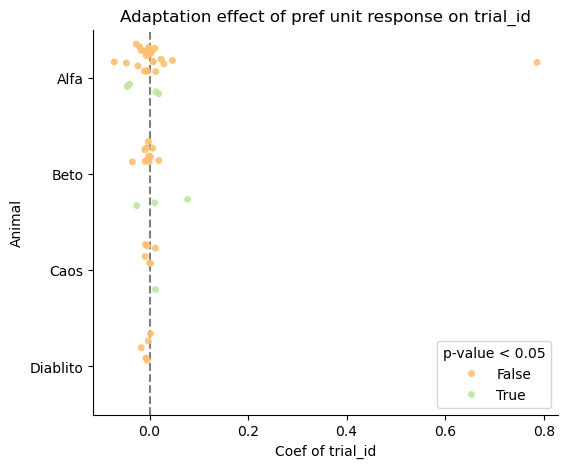

In [20]:
# jitter plot the coef value and use different color for pvalue < 0.01
adaptation_effect_df['sig'] = adaptation_effect_df['pvalue'] < 0.05
figh = plt.figure(figsize=(6, 5))
sns.stripplot(data=adaptation_effect_df, x="coef", y="Animal", hue="sig", palette="Spectral", 
              alpha=0.9, jitter=0.3, dodge=True, order=["Alfa", "Beto", "Caos", "Diablito"])
plt.axvline(x=0, color="black", linestyle="--", alpha=0.5)
plt.title("Adaptation effect of pref unit response on trial_id")
plt.xlabel("Coef of trial_id")
plt.ylabel("Animal")
plt.legend(title="p-value < 0.05", loc="lower right")
saveallforms(syndir, "adaptation_effect_synopsis_stripplot", figh)
plt.show()

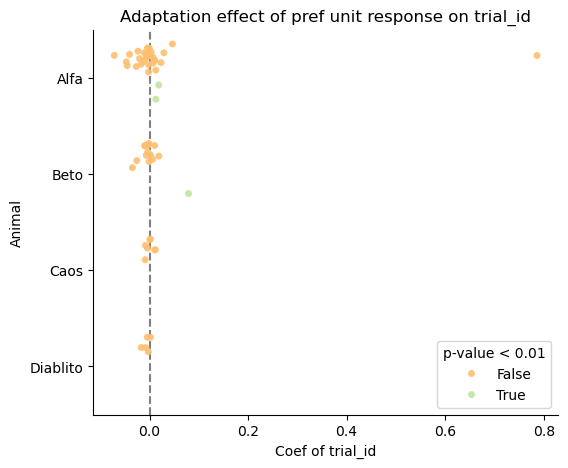

In [19]:
# jitter plot the coef value and use different color for pvalue < 0.01
adaptation_effect_df['sig'] = adaptation_effect_df['pvalue'] < 0.01
figh = plt.figure(figsize=(6, 5))
sns.stripplot(data=adaptation_effect_df, x="coef", y="Animal", hue="sig", palette="Spectral", 
              alpha=0.9, jitter=0.3, dodge=True, order=["Alfa", "Beto", "Caos", "Diablito"])
plt.axvline(x=0, color="black", linestyle="--", alpha=0.5)
plt.title("Adaptation effect of pref unit response on trial_id")
plt.xlabel("Coef of trial_id")
plt.ylabel("Animal")
plt.legend(title="p-value < 0.01", loc="lower right")
saveallforms(syndir, "adaptation_effect_synopsis_stripplot_sig001", figh)
plt.show()

In [13]:
adaptation_effect_df

Animal  Expi                ephysFN  pref_chan  pref_unit      coef    tvalue    pvalue     Fvalue   Fpvalue   intercept        r2    N    sig
0       Caos   1.0      Caos-12022024-003       91.0        2.0 -0.008438 -1.611856  0.110745   2.598078  0.110745   15.451922  0.030002   86  False
1       Caos   2.0      Caos-12022024-006       94.0        1.0  0.001916  0.425304  0.671190   0.180883  0.671190   87.835277  0.001136  161  False
2       Caos   3.0      Caos-12042024-003       71.0        2.0 -0.004269 -0.680323  0.497611   0.462839  0.497611   78.619888  0.003842  122  False
3       Caos   4.0      Caos-12042024-007       72.0        1.0  0.011590  1.006922  0.316086   1.013892  0.316086  180.216888  0.008739  117  False
4       Caos   5.0      Caos-12092024-004       92.0        2.0  0.000433  0.411002  0.681536   0.168923  0.681536   15.771461  0.000893  191  False
5       Caos   6.0      Caos-12102024-003       68.0        2.0 -0.008983 -1.909774  0.058009   3.647236  0.058009  109.455826  0.022990  157  False
6       Caos   7.0      Caos-12102024-006       69.0        1.0  0.010368  2.211543  0.027974   4.890922  0.027974  136.144228  0.020646  234  False
7   Diablito   1.0  Diablito-03122024-003       56.0        1.0 -0.016920 -1.528417  0.129155   2.336059  0.129155  119.841647  0.019909  117  False
8   Diablito   2.0  Diablito-11122024-003       42.0        2.0 -0.004709 -1.178618  0.240655   1.389141  0.240655   67.023585  0.010337  135  False
9   Diablito   3.0  Diablito-11122024-005       34.0        2.0  0.001834  0.589473  0.556233   0.347479  0.556233   66.183726  0.001797  195  False
10  Diablito   4.0  Diablito-12122024-004       64.0        2.0 -0.007691 -1.559937  0.121522   2.433405  0.121522   37.363450  0.020722  117  False
11  Diablito   5.0  Diablito-12122024-006       50.0        1.0 -0.002599 -0.445354  0.656694   0.198340  0.656694  125.721534  0.001295  155  False
12      Alfa   1.0      Alfa-04082020-003       22.0        1.0 -0.002124 -0.491504  0.624267   0.241576  0.624267   32.921019  0.002677   92  False
13      Alfa   2.0      Alfa-06082020-004        6.0        1.0  0.007445  1.173806  0.243676   1.377819  0.243676   50.791363  0.015590   89  False
14      Alfa   2.0      Alfa-10082020-004        6.0        1.0 -0.000835 -0.196760  0.844392   0.038715  0.844392   52.519643  0.000365  108  False
15      Alfa   3.0      Alfa-12082020-004       29.0        1.0 -0.005392 -0.729956  0.467074   0.532835  0.467074  110.868521  0.005147  105  False
16      Alfa   4.0      Alfa-14082020-003       51.0        1.0  0.018709  2.966357  0.003545   8.799276  0.003545  101.869055  0.059135  142   True
17      Alfa   5.0      Alfa-25082020-007       59.0        1.0  0.010827  0.608702  0.544982   0.370518  0.544982   59.024390  0.006037   63  False
18      Alfa   6.0      Alfa-27082020-003        7.0        1.0 -0.004310 -1.072860  0.284803   1.151028  0.284803   85.678172  0.006497  178  False
19      Alfa   7.0      Alfa-01092020-004       52.0        1.0  0.006563  0.903964  0.367454   0.817152  0.367454  144.099098  0.005382  153  False
20      Alfa   8.0      Alfa-02092020-004       64.0        1.0  0.012529  1.444925  0.150579   2.087808  0.150579  226.672267  0.013819  151  False
21      Alfa   9.0      Alfa-02092020-006       49.0        1.0  0.003011  0.369520  0.712381   0.136545  0.712381   92.794690  0.001118  124  False
22      Alfa  10.0      Alfa-08092020-004       57.0        1.0 -0.010791 -1.644583  0.102109   2.704655  0.102109  170.293201  0.017370  155  False
23      Alfa  11.0      Alfa-11092020-003       32.0        1.0 -0.006546 -1.586122  0.114818   2.515782  0.114818   31.211224  0.016495  152  False
24      Alfa  12.0      Alfa-11092020-006       30.0        1.0 -0.010551 -1.612139  0.109559   2.598992  0.109559   80.875290  0.021199  122  False
25      Alfa  13.0      Alfa-16092020-003       10.0        1.0  0.003089  0.663327  0.508132   0.440003  0.508132   90.384613  0.00

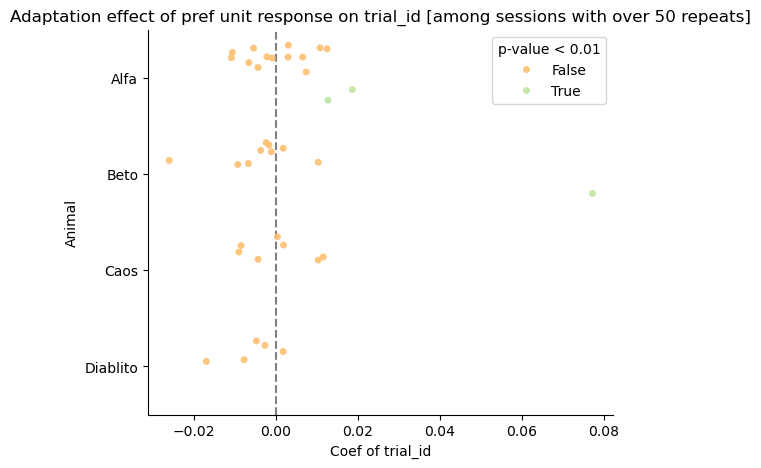

In [16]:
# jitter plot the coef value and use different color for pvalue < 0.01
adaptation_effect_df['sig'] = adaptation_effect_df['pvalue'] < 0.01
figh = plt.figure(figsize=(6, 5))
sns.stripplot(data=adaptation_effect_df.query("N > 50"), x="coef", y="Animal", hue="sig", palette="Spectral", 
              alpha=0.9, jitter=0.3, dodge=True, order=["Alfa", "Beto", "Caos", "Diablito"])
plt.axvline(x=0, color="black", linestyle="--", alpha=0.5)
plt.title("Adaptation effect of pref unit response on trial_id [among sessions with over 50 repeats]")
plt.xlabel("Coef of trial_id")
plt.ylabel("Animal")
plt.legend(title="p-value < 0.01", loc="upper right")
saveallforms(syndir, "adaptation_effect_synopsis_stripplot_sig001_over50", figh)
plt.show()

In [10]:
adaptation_effect_df.value_counts("sig")

sig
False    52
True      3
Name: count, dtype: int64

In [22]:
adaptation_effect_df['sig'] = adaptation_effect_df['pvalue'] < 0.01
adaptation_effect_df.query("N > 50").value_counts("sig")

sig
False    34
True      3
Name: count, dtype: int64